In [204]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import re
import multiprocessing
from collections import Counter
import itertools
import json
from IPython.display import display as disp
from dateutil.parser import parse as dtparse

from sklearn import decomposition
import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=2.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
%matplotlib inline
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]
mpl.rcParams['text.usetex'] = True

from importlib import reload as reloadmodule

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, graph, plotting, userActivityFunctions

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

# import pixiedust

mpl.rcParams['figure.figsize'] = [12, 7] 

In [175]:
COMPUTE_PCA = False

In [125]:
%config IPCompleter.use_jedi = False

In [126]:
mpl.rcParams['figure.figsize'] = [12, 7] 

# Load and clean data

In [127]:
df = pd.io.pytables.read_hdf('../../allan_data/phone_df.h5', 'df')
import pickle
with open('useralias.pk', 'br') as fid:
    ua = pickle.load(fid)
phonebook = loaders.loadUserPhonenumberDict(ua) 
df.head() 

body  duration  hour                                    number     timeint           timestamp  weekday
user  comtype                                                                                                        
u0001 call     NaN      29.0    15  36a4861f3f67cbf88b578d77743d1f5a8ddf604f  1386255771 2013-12-05 15:02:51        3
      call     NaN       0.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6  1386330792 2013-12-06 11:53:12        4
      call     NaN      89.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6  1386330838 2013-12-06 11:53:58        4
      call     NaN     104.0    13  36a4861f3f67cbf88b578d77743d1f5a8ddf604f  1386509631 2013-12-08 13:33:51        6
      call     NaN      32.0    18  36a4861f3f67cbf88b578d77743d1f5a8ddf604f  1386526906 2013-12-08 18:21:46        6

In [128]:
original_number_of_rows = df.shape[0] 

Remove call to users not in phonebook.

In [129]:
df = df[df.number.isin(phonebook)] 

Add _contactedUser_ column and remove the _number_ column.

In [130]:
df['contactedUser'] = df.number.apply(lambda x: phonebook[x]) 
df = df.drop('number', axis=1)

In [131]:
df.head() 

body  duration  hour     timeint           timestamp  weekday contactedUser
user  comtype                                                                            
u0001 call     NaN       0.0     1  1390698006 2014-01-26 01:00:06        6         u0493
      call     NaN       0.0    14  1391176805 2014-01-31 14:00:05        4         u0493
      call     NaN      29.0    14  1391782631 2014-02-07 14:17:11        4         u0117
      call     NaN      22.0    14  1391782712 2014-02-07 14:18:32        4         u0493
      call     NaN       3.0    14  1394805935 2014-03-14 14:05:35        4         u0117

In [132]:
df = df[df.timestamp >= '2013-07-01'] 

In [133]:
monthNameLookup = {1: 'Jan.', 2: 'Feb.', 3: 'Mar.', 4: 'Apr.', 5: 'May', 6: 'June',
                   7: 'July', 8: 'Aug.', 9: 'Sept.', 10: 'Oct.', 11: 'Nov.', 12: 'Dec.'}

grp = df.groupby([df.timestamp.dt.year, df.timestamp.dt.month]) 

In [134]:
# Change to to timeseries index
ddf = df.reset_index().set_index('timestamp')
ddf.index = pd.to_datetime(ddf.index)  # ensure that it's a timeseries... probably redundant

# ****************************************************************************
# *                   # Split into call and sms DataFrames                   *
# ****************************************************************************

# Call DataFrame
ddf_call = ddf.loc[ddf.comtype == 'call']  # make split
# Groupby and fix index: Yesr, Month -> timeseries
ddf_call = ddf_call.groupby([ddf_call.index.year, ddf_call.index.month]).timeint.count() 
ddf_call.index.names = ('year', 'month') 
idx_call = [dtparse(f"{year}/{month}") for (year, month) in
            zip(ddf_call.index.get_level_values(0), ddf_call.index.get_level_values(1))]
ddf_call.index = idx_call 
# Make it a DataFrame
ddf_call = pd.DataFrame(ddf_call)
ddf_call = ddf_call.rename(columns={'timeint': 'Call'})

# SMS DataFrame
ddf_sms = ddf.loc[ddf.comtype == 'sms']
# Groupby and fix index: Yesr, Month -> timeseries
ddf_sms = ddf_sms.groupby([ddf_sms.index.year, ddf_sms.index.month]).timeint.count()
ddf_sms.index.names = ('year', 'month') 
idx_sms = [dtparse(f"{year}/{month}") for (year, month) in
           zip(ddf_sms.index.get_level_values(0), ddf_sms.index.get_level_values(1))]
ddf_sms.index = idx_sms
# Make it a DataFrame
ddf_sms = pd.DataFrame(ddf_sms)
ddf_sms = ddf_sms.rename(columns={'timeint': 'SMS'})

# Join sms and call DataFrame
ddfc = ddf_call.join(ddf_sms)
del ddf_call, ddf_sms


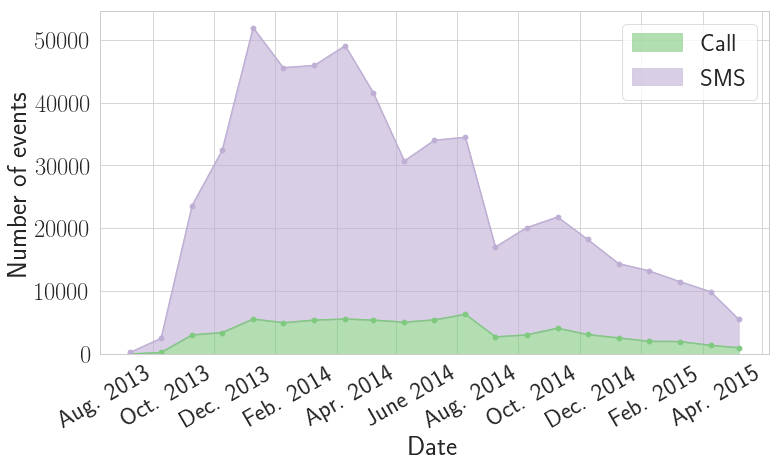

In [135]:
fig, ax = plt.subplots()
ddfc.plot.area(stacked=True, alpha=0.6, ax=ax)
fig.canvas.draw()

year, month = list(zip(*[el.get_text().split('-') for el in ax.get_xticklabels()]))
month = [monthNameLookup[int(mnt)] for mnt in month] 
xticks = [f"{month} {year}" for (year, month) in zip(year, month)]
ax.set_xticklabels(xticks); 

ddfc.Call.plot(marker='o', color=colorcycle[0], ax=ax)
ddfc.sum(axis=1).plot(marker='o', color=colorcycle[1], ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Number of events")
fig.canvas.draw() 
fig.savefig("figs/cleaned_call_and_sms_data_stacked_by_month.pdf")

Remove entries with users contacting themself

In [136]:
tmp = df.reset_index() 
tmp = tmp[(tmp.user != tmp.contactedUser)]
df = tmp.set_index(['user', 'comtype'], drop=False)
del tmp

In [137]:
df.head()

user comtype body  duration  hour     timeint           timestamp  weekday contactedUser
user  comtype                                                                                           
u0001 call     u0001    call  NaN       0.0     1  1390698006 2014-01-26 01:00:06        6         u0493
      call     u0001    call  NaN       0.0    14  1391176805 2014-01-31 14:00:05        4         u0493
      call     u0001    call  NaN      29.0    14  1391782631 2014-02-07 14:17:11        4         u0117
      call     u0001    call  NaN      22.0    14  1391782712 2014-02-07 14:18:32        4         u0493
      call     u0001    call  NaN       3.0    14  1394805935 2014-03-14 14:05:35        4         u0117

In [138]:
cleaned_number_of_rows = df.shape[0] 

In [139]:
original_number_of_rows

4922754

In [140]:
cleaned_number_of_rows

508811

This many percent data was discarded

In [141]:
(1 - cleaned_number_of_rows/original_number_of_rows)*100

89.66409859196702

In [142]:
n_call = df.xs('call', level=1).shape[0]
n_sms = df.xs('sms', level=1).shape[0]

n_sms / n_call

6.1591929197563005

# Finding cliques

NetworkX needs an undirected graph to find cliques, so that's what we'll construct.

We'll remove contacts with fewer than 3 communication events.

In [143]:
com = df.groupby('user').contactedUser.value_counts() 
com.head(12) 

/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'user' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


user   contactedUser
u0001  u0493            121
       u0117             40
       u0783              6
       u0392              1
       u0791              1
u0002  u0796            108
       u0499             53
       u0287             30
       u0464             25
       u0592             23
       u0444             19
       u0211             18
Name: contactedUser, dtype: int64

In [176]:
com = com[com >= 3]

edges = com.index.tolist()

In [177]:
edges[:8]

[('u0001', 'u0493'),
 ('u0001', 'u0117'),
 ('u0001', 'u0783'),
 ('u0002', 'u0796'),
 ('u0002', 'u0499'),
 ('u0002', 'u0287'),
 ('u0002', 'u0464'),
 ('u0002', 'u0592')]

Construct the binary graph, find the cliques, and sort them by descending size, and remove cliques smaller than 3

In [178]:
g_dir = nx.DiGraph()
g_dir.add_edges_from(edges)

g_bin_rcp = g_dir.to_undirected(reciprocal=True)

In [179]:
cliques = pd.DataFrame([clq for clq in nx.algorithms.clique.find_cliques(g_bin_rcp) if len(clq) > 2])
cliques = cliques.iloc[np.argsort(cliques.count(axis=1))[::-1]]
cliques = cliques.reset_index(drop=True)
cliques.head() 

,0,1,2,3,4,5
0,u0446,u0645,u0683,u0993,u0388,u0618
1,u0568,u0813,u0544,u0228,u0176,None
2,u0154,u0128,u0491,u0758,u0813,None
3,u0154,u0128,u0491,u0758,u0489,None
4,u0324,u0287,u0128,u0444,u0477,None


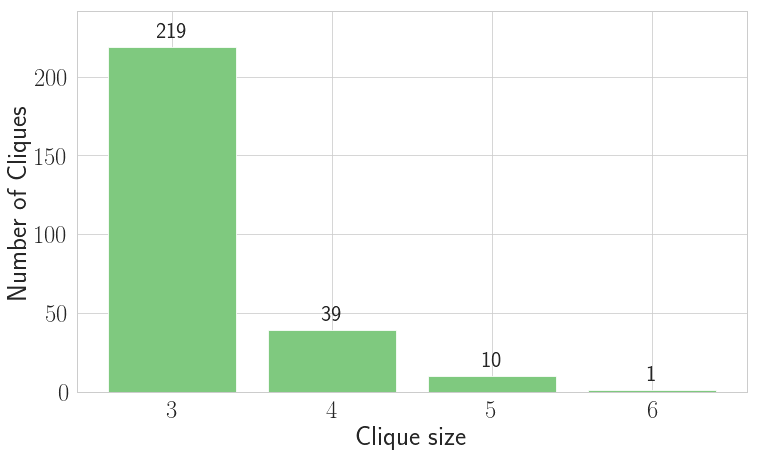

In [180]:
fig, ax = plt.subplots()
ax.bar([3,4,5,6], cliques.count(axis=1).value_counts())
ax.set_xlabel("Clique size")
ax.set_ylabel("Number of Cliques")
ax.set_xticks((3, 4, 5, 6))
plotting.looseAxesLimits(ax, (0, 0, 0, 0.05))
plotting.countsOnBarPlot(ax, fontsize=22)
fig.savefig("figs/clique_size_distribution_reciprocal.pdf")

In [181]:
g_bin = nx.Graph()
g_bin.add_edges_from(edges)
cliques = pd.DataFrame([clq for clq in nx.algorithms.clique.find_cliques(g_bin) if len(clq) > 2])
cliques = cliques.iloc[np.argsort(cliques.count(axis=1))[::-1]]
cliques = cliques.reset_index(drop=True)
cliques.head() 

,0,1,2,3,4,5,6
0,u0446,u0645,u0676,u0683,u0993,u0388,u0618
1,u0489,u0128,u0491,u0813,u0287,u0758,None
2,u0324,u0226,u0607,u0211,u0073,u0930,None
3,u0154,u0128,u0491,u0813,u0489,u0758,None
4,u0033,u0655,u0396,u0314,u0749,u0128,None


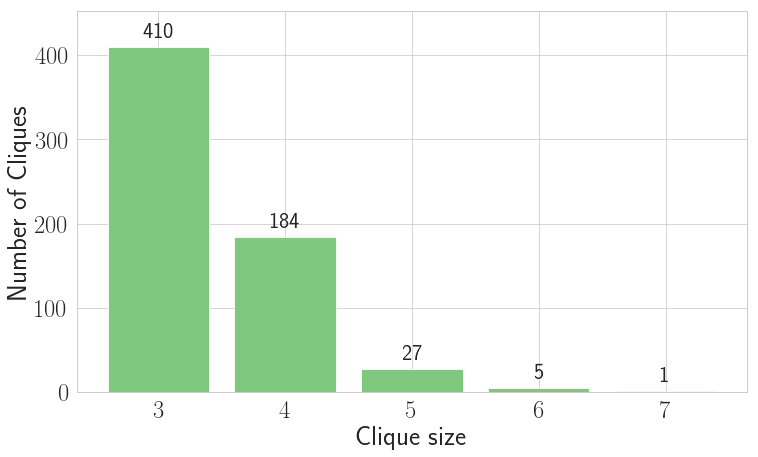

In [182]:
fig, ax = plt.subplots()
ax.bar([3,4,5,6,7], cliques.count(axis=1).value_counts())
ax.set_xlabel("Clique size")
ax.set_ylabel("Number of Cliques")
ax.set_xticks((3, 4, 5, 6, 7))
plotting.looseAxesLimits(ax, (0, 0, 0, 0.05))
plotting.countsOnBarPlot(ax, fontsize=22)
fig.savefig("figs/clique_size_distribution.pdf")

# Construct timebinned adjacency matrices for users, and do the stacking-PCA


### Determine start time offset for the binning 

Find the first occuring communication...

In [159]:
t0 = df.timestamp.min()
t0

Timestamp('2013-07-02 19:07:49')

…and choose the corresponding day...

In [160]:
t0d = pd.Timestamp(t0.date())
t0d

Timestamp('2013-07-02 00:00:00')

Since the timeint is in seconds, but Pandas keeps it's records in nanoseconds, the integer representation of the date needs to be divided by 1e9.

To check that this is indeed true, compare the values of the integer casted `t0` to the timeint for the corresponding row:

In [161]:
np.int64(t0.value // 1e9) == df.loc[df.timestamp.idxmin()].timeint.values[0]

True

Since it was true, use the following for the bin time start

In [162]:
t0d = np.int64(t0d.value // 1e9)
t0 = np.int64(t0.value // 1e9) 
t0d

1372723200

Binning is simply performed by integer division with a suiting bin width.
I choose 8 hours:

In [163]:
bw8h = 60**2*8
df['tbin'] = (df.timeint - t0d) // bw8h
df.head()

user comtype body  duration  hour     timeint           timestamp  weekday contactedUser  tbin
user  comtype                                                                                                 
u0001 call     u0001    call  NaN       0.0     1  1390698006 2014-01-26 01:00:06        6         u0493   624
      call     u0001    call  NaN       0.0    14  1391176805 2014-01-31 14:00:05        4         u0493   640
      call     u0001    call  NaN      29.0    14  1391782631 2014-02-07 14:17:11        4         u0117   661
      call     u0001    call  NaN      22.0    14  1391782712 2014-02-07 14:18:32        4         u0493   661
      call     u0001    call  NaN       3.0    14  1394805935 2014-03-14 14:05:35        4         u0117   766

Does it make sense to start the bins a midnight?

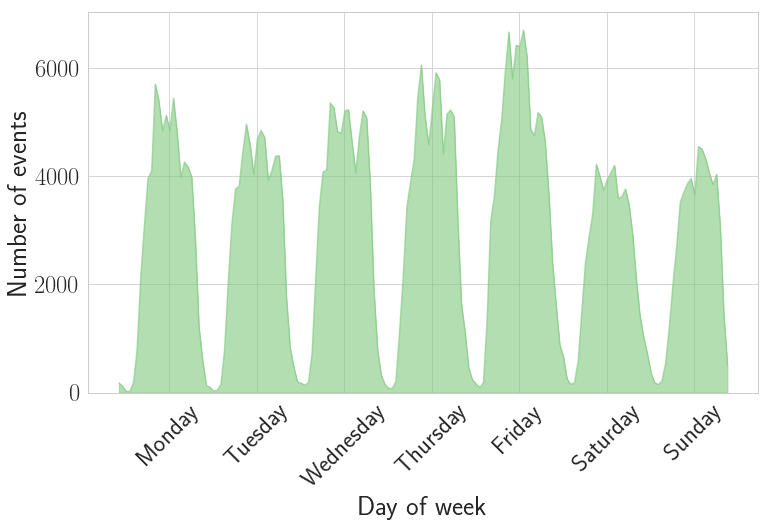

In [166]:
grp = df.groupby([df.timestamp.dt.dayofweek, df.timestamp.dt.hour]).timeint.count()  

grp.index = pd.TimedeltaIndex(freq='H', start=0, periods=24*7) 

fig, ax = plt.subplots()
grp.plot.area(alpha=0.6, ax=ax) 
ax.set_xticks( pd.TimedeltaIndex(freq='D', periods=7, start=0).values.astype(float)+5e13 )
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_ylabel("Number of events")
ax.set_xlabel("Day of week")
ax.xaxis.set_tick_params(rotation=45) 
fig.savefig("figs/weekly_activity_by_hour.pdf")

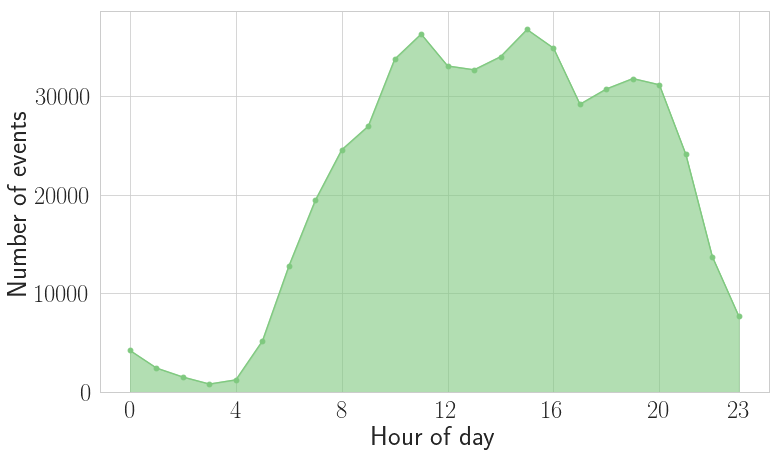

In [167]:
grp = df.groupby(df.timestamp.dt.hour).timeint.count() 
fig, ax = plt.subplots()
grp.plot.area(alpha=0.6, ax=ax) 
grp.plot(kind='line', color=colorcycle[0], style='-o', ax=ax) 
ax.set_xlabel("Hour of day")
ax.set_ylabel("Number of events")
ax.set_xticks([0, 4, 8, 12, 16, 20, 23]) 
fig.savefig("figs/dayly_events_by_hour.pdf") 

Test it with a 5-clique

In [240]:
tryout_clique = cliques[(cliques.count(axis=1) == 5)].iloc[0].dropna().tolist() 
print(*tryout_clique, sep='\t')

u0889	u0226	u0607	u0073	u0930


In [241]:
pca = userActivityFunctions.community2Pca(df, tryout_clique, 'tbin', nx.Graph,
                                          fitFunctionKwargs={'performStandardization': False})
print(f'pca.components_.shape : {pca.components_.shape}', sep='\n', end='\n\n')
print(f'pca.explained_variance_ratio_ : {pca.explained_variance_ratio_}', sep='\n', end='\n\n') 

pca.components_.shape : (10, 86)

pca.explained_variance_ratio_ : [4.36857829e-01 1.55242123e-01 1.10908268e-01 9.76430342e-02 8.84491311e-02 5.55386921e-02 2.92917883e-02 1.88605125e-02 7.20862128e-03
 2.35415792e-32]



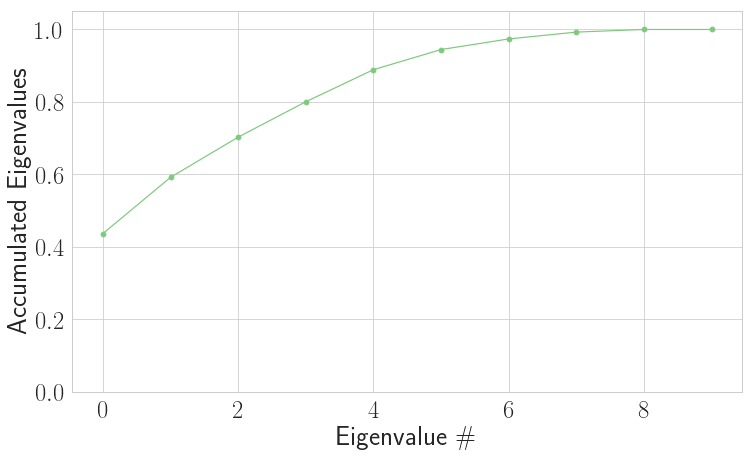

In [242]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.set_ylim([0, 1.05])
ax.set_xlabel("Eigenvalue \\#")
ax.set_ylabel("Accumulated Eigenvalues")
fig.savefig(f"figs/pca_{len(pca.community_)}_clique_undirected_eigenvalues_cumsum.pdf") 

Define a custom weight-function for the graph edges plotting routine.
Very bold edges are required, because the figures will be rather small in the report.

In [243]:
weightFunc = lambda g: [3 + 8*wt/max(g.es['weight']) for wt in g.es['weight']] 

The first 7 componentes explain 95 % of the variance — plotted below


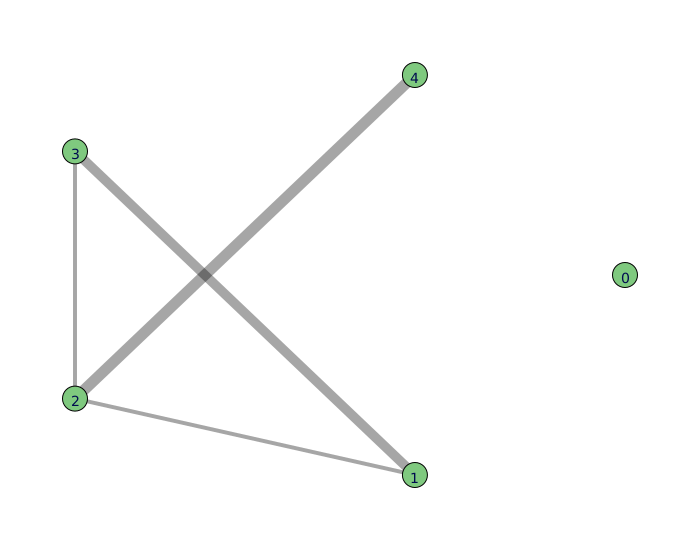

0.4368578293181868


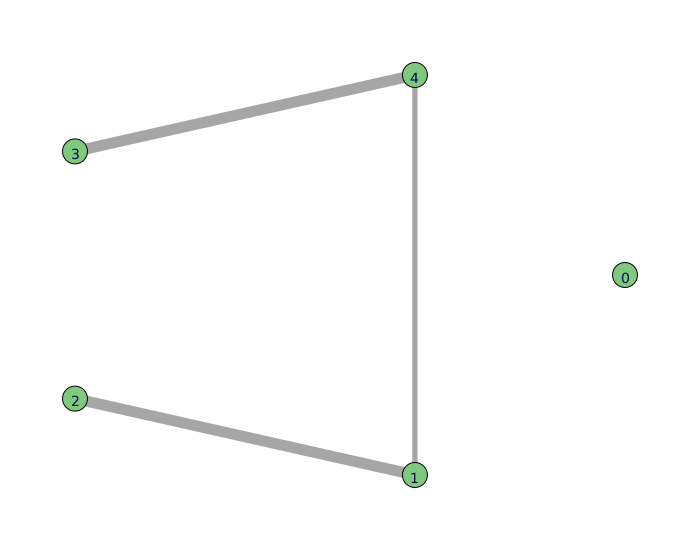

0.1552421232770913


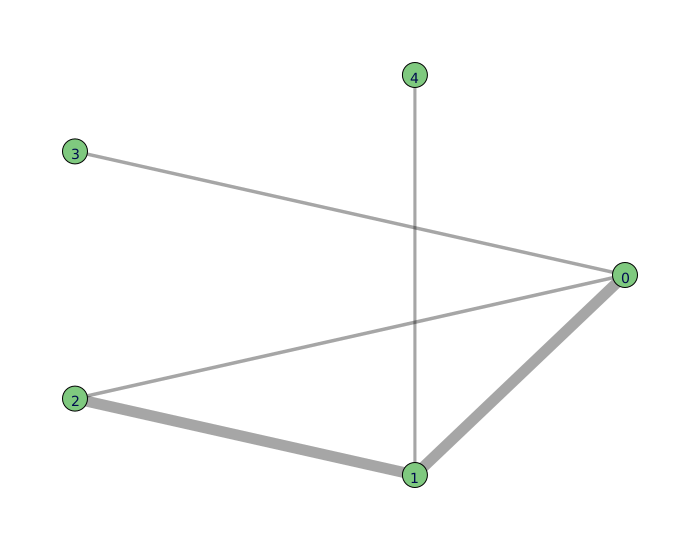

0.11090826796242982


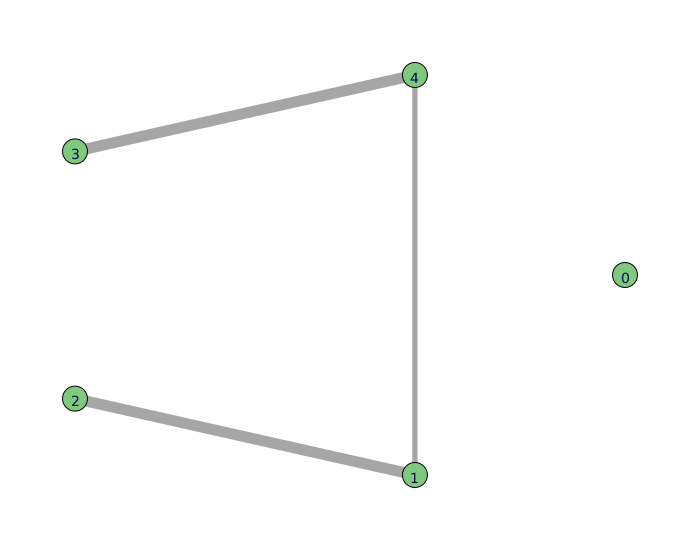

0.09764303422052784


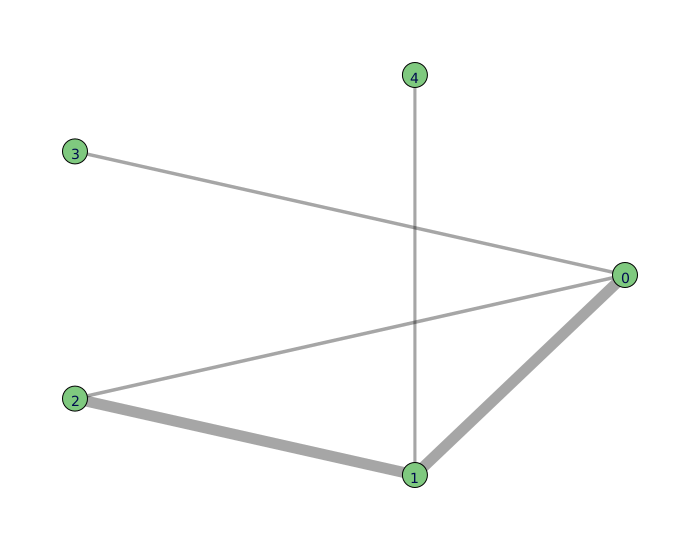

0.08844913106180374


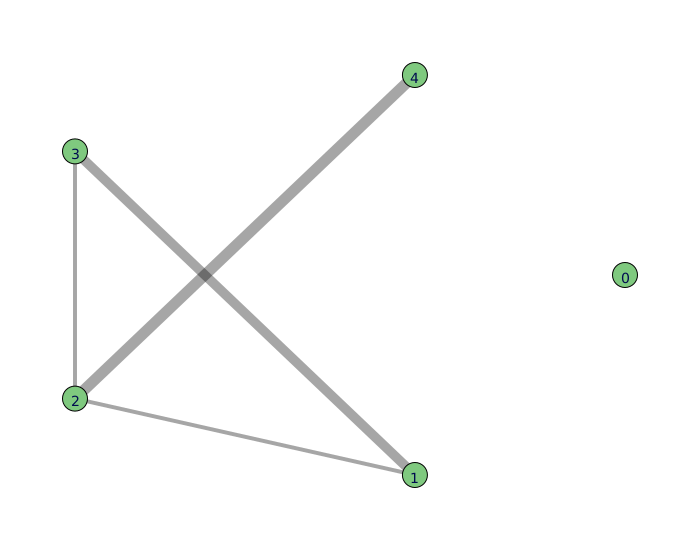

0.055538692066579055


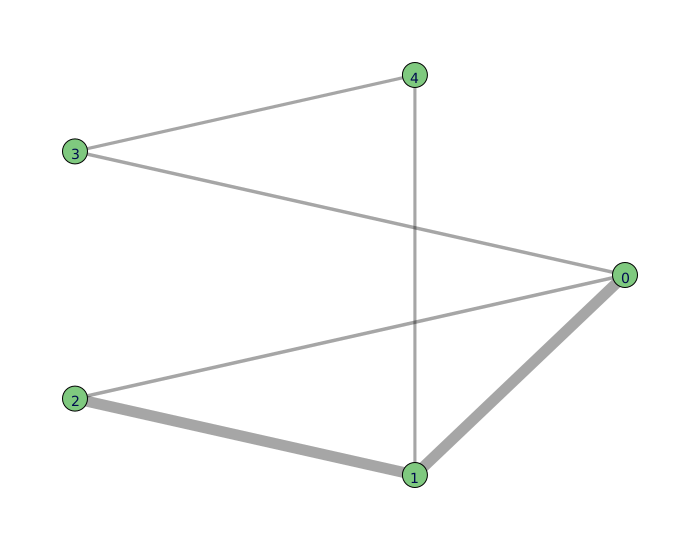

0.02929178832812498


In [244]:
n_to_plot = (np.cumsum(pca.explained_variance_ratio_) <= 0.95).sum() + 1
print(f"The first {n_to_plot} componentes explain 95 % of the variance — plotted below")

layout = None
keepsies_dct = dict()
keepsies_idx = (2, 4) 
for i in range(n_to_plot):
    am = graph.upperTril2adjMat(pca.components_[:, i]) 
    if i in keepsies_idx:
        keepsies_dct[f"{i}_before_pruning"] = am.copy()
    am[am < 1e-5] = 0
    if i in keepsies_idx:
        keepsies_dct[f"{i}_after_pruning"] = am.copy()
    g_pca = nx.from_numpy_matrix(am)
    if layout is None:
        layout = graph.nx2ig(g_pca).layout('circle')
    filename = f"figs/pca_graph_{len(pca.community_)}_undirected_clique_component_{i+1}_of_{n_to_plot}.pdf"
    disp(plotting.igdraw(g_pca, filename=filename, layout=layout, weightFunc=weightFunc))
    print(pca.explained_variance_ratio_[i])

Inspect the adjacency matrices for two very similar looking graphs.

In [245]:
for k, v in keepsies_dct.items():
    print(k)
    print(v, end='\n\n')

2_before_pruning
[[ 0.          0.17210095  0.01132904  0.01009205 -0.01145298]
 [ 0.17210095  0.          0.00229757 -0.00794947  0.00446324]
 [ 0.01132904  0.00229757  0.         -0.00233264 -0.00989857]
 [ 0.01009205 -0.00794947 -0.00233264  0.         -0.40699334]
 [-0.01145298  0.00446324 -0.00989857 -0.40699334  0.        ]]

2_after_pruning
[[0.         0.17210095 0.01132904 0.01009205 0.        ]
 [0.17210095 0.         0.00229757 0.         0.00446324]
 [0.01132904 0.00229757 0.         0.         0.        ]
 [0.01009205 0.         0.         0.         0.        ]
 [0.         0.00446324 0.         0.         0.        ]]

4_before_pruning
[[ 0.          0.05736698  0.00377635  0.00336402 -0.00381766]
 [ 0.05736698  0.          0.00076586 -0.00264982  0.00148775]
 [ 0.00377635  0.00076586  0.         -0.00077755 -0.00329952]
 [ 0.00336402 -0.00264982 -0.00077755  0.         -0.02082756]
 [-0.00381766  0.00148775 -0.00329952 -0.02082756  0.        ]]

4_after_pruning
[[0.    

Try with a directed graph

In [246]:
pca = userActivityFunctions.community2Pca(df, tryout_clique, 'tbin', nx.DiGraph, excludeDiagonal=True,
                                          fitFunctionKwargs={'performStandardization': False})
print(f'pca.components_.shape : {pca.components_.shape}', sep='\n', end='\n\n')
print(f'pca.explained_variance_ratio_ : {pca.explained_variance_ratio_}', sep='\n', end='\n\n')  

pca.components_.shape : (20, 86)

pca.explained_variance_ratio_ : [3.38552453e-01 1.46395677e-01 1.20826852e-01 1.07703348e-01 6.73792087e-02 6.40210628e-02 4.87056569e-02 3.67568285e-02 2.49913121e-02
 1.50594240e-02 1.15858706e-02 1.02909089e-02 5.54487911e-03 1.85985109e-03 3.26667139e-04 4.08777675e-32 1.15592833e-33 3.29141283e-34
 1.86946911e-34 3.88872440e-38]



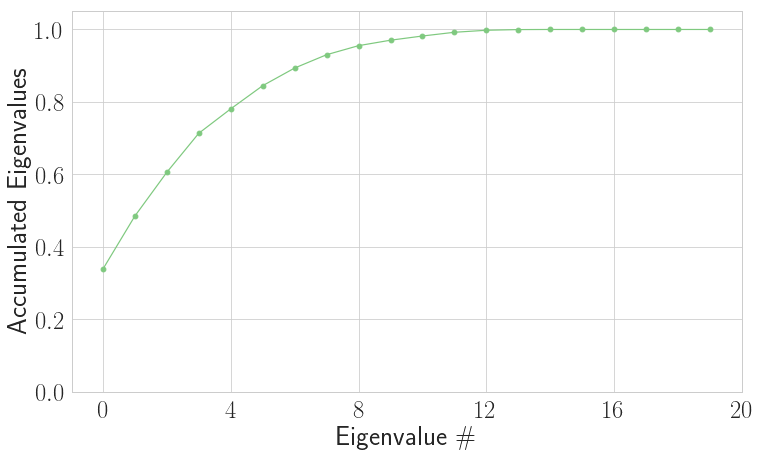

In [247]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.set_ylim([0, 1.05])
ax.set_xticks(np.arange(0, 21, 4))
ax.set_xlabel("Eigenvalue \\#")
ax.set_ylabel("Accumulated Eigenvalues")
fig.savefig(f"figs/pca_{len(pca.community_)}_clique_directed_eigenvalues_cumsum.pdf") 

The first 9 componentes explain 95 % of the variance — plotted below


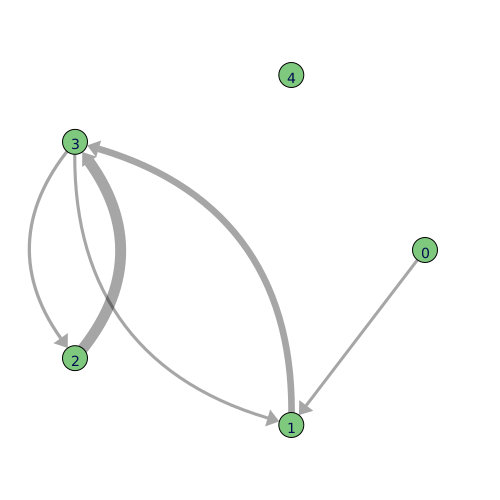

0.3385524528265308


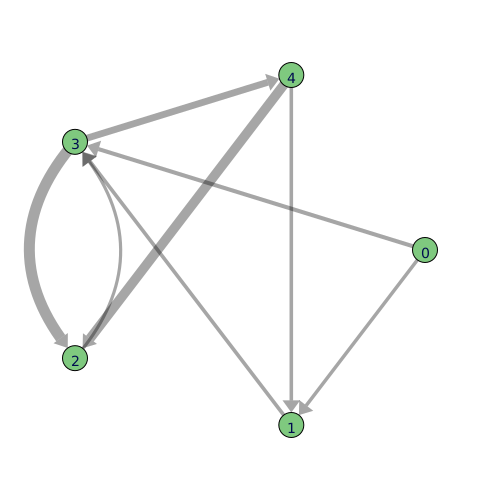

0.14639567726292838


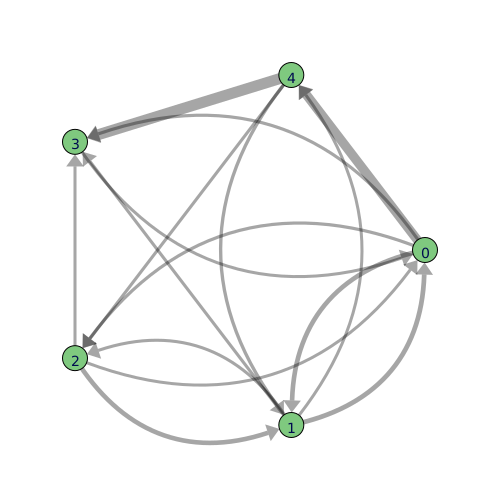

0.12082685197815325


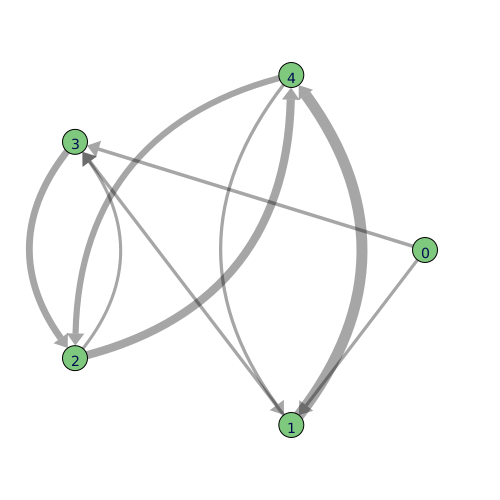

0.10770334813552777


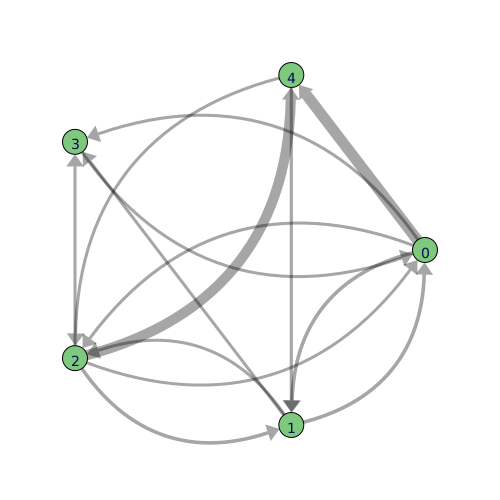

0.06737920866339915


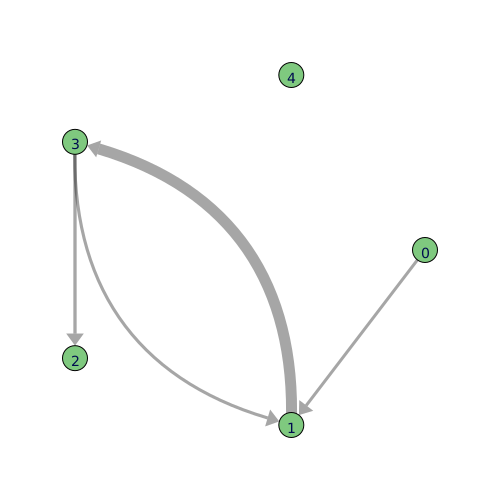

0.06402106283584778


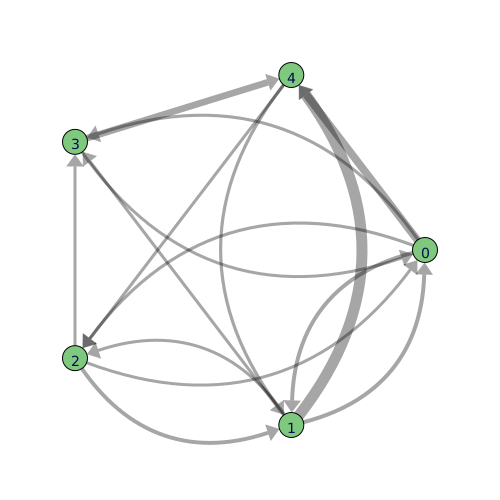

0.0487056569201804


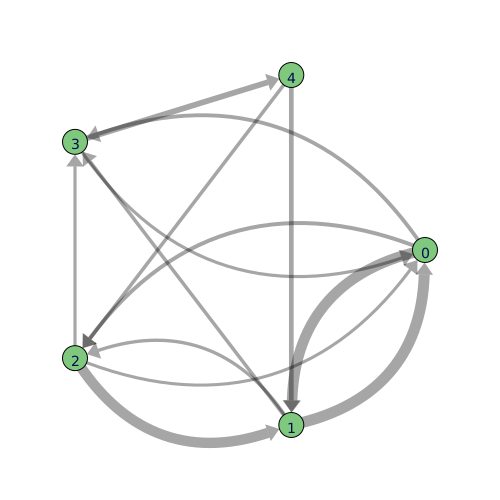

0.036756828494563056


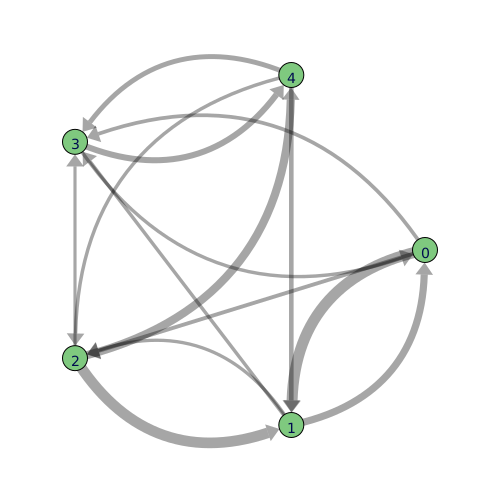

0.024991312065725035


In [261]:
n_to_plot = (np.cumsum(pca.explained_variance_ratio_) <= 0.95).sum() + 1
print(f"The first {n_to_plot} componentes explain 95 % of the variance — plotted below") 
layout = None
for i in range(n_to_plot):
    am = graph.vec2squareMat(pca.components_[:, i], addDiagonal=True) 
    # amorg = am.copy() 
    # am += np.abs(am.min())
    # am[np.eye(am.shape[0], dtype=bool)] = 0  # make the diagonal 0 again
    # am[am < am.max()/100] = 0
    am[am < 1e-5] = 0
    g_pca = nx.from_numpy_matrix(am, create_using=nx.DiGraph())
    if layout is None:
        layout = graph.nx2ig(g_pca).layout('circle') 
    filename = f"figs/pca_graph_{len(pca.community_)}_directed_clique_component_{i+1}_of_{n_to_plot}.pdf"
    disp(plotting.igdraw(g_pca, filename=filename, bbox=(500, 500), layout=layout,
                         weightFunc=weightFunc, edge_arrow_width=22))
    print(pca.explained_variance_ratio_[i]) 

# Do it for _all_ cliques

Args for multiprocessing.

Since the arguments symmetric = True/False are monkay-patched onto the PCA object, we can easily identify what we whether a Graph or DiGraph was used to create the adjacency matrices in use.

In [48]:
try:
    del args_lst
except NameError:
    pass

args_lst = list()
for ri, row in cliques.iterrows():
    clq = row.dropna().tolist()
    
    args = (
    df,           #  userDf
    clq,          #  community
    'tbin',       #  binColumn
    nx.DiGraph,   #  graphtype
    False,        #  excludeDiagonal
    misc.pcaFit,  #  fitFunction
    {'performStandardization': False},         #  fitFunctionKwargs
    -ri           #  printProgress
    )
    args_lst.append(args)

    args = (
    df,           #  userDf
    clq,          #  community
    'tbin',       #  binColumn
    nx.Graph,     #  graphtype
    False,        #  excludeDiagonal
    misc.pcaFit,  #  fitFunction
    {'performStandardization': False},         #  fitFunctionKwargs
    ri            #  printProgress
    )
    args_lst.append(args) 

In [49]:
len(args_lst)

1254

In [50]:
pca = userActivityFunctions.community2Pca(*args_lst[-1])
pca

Clique number 626 processed, members: ('u0814', 'u0241', 'u0660')


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Seems to work when evaluated on the local Python process

In [51]:
if COMPUTE_PCA:
    with multiprocessing.Pool(processes=30) as pool:
        pca_result_pool = pool.starmap(userActivityFunctions.community2Pca, args_lst)

Clique number -11 processed, members: ('u0122', 'u0392', 'u0709', 'u0264', 'u0739')
Clique number 5 processed, members: ('u0324', 'u0287', 'u0128', 'u0758', 'u0491', 'u0813')
Clique number -6 processed, members: ('u0889', 'u0226', 'u0607', 'u0073', 'u0930')
Clique number 11 processed, members: ('u0122', 'u0392', 'u0709', 'u0264', 'u0739')
Clique number 6 processed, members: ('u0889', 'u0226', 'u0607', 'u0073', 'u0930')
Clique number -22 processed, members: ('u0324', 'u0287', 'u0818', 'u0758', 'u0813')
Clique number 16 processed, members: ('u0122', 'u0392', 'u0241', 'u0739', 'u0264')
Clique number -12 processed, members: ('u0228', 'u0813', 'u0128', 'u0287', 'u0758')
Clique number -33 processed, members: ('u0149', 'u0011', 'u0768', 'u0943')
Clique number -7 processed, members: ('u0324', 'u0287', 'u0818', 'u0758', 'u0951')
Clique number 12 processed, members: ('u0228', 'u0813', 'u0128', 'u0287', 'u0758')
Clique number 22 processed, members: ('u0324', 'u0287', 'u0818', 'u0758', 'u0813')
Cl

Clique number -31 processed, members: ('u0278', 'u0166', 'u0844', 'u0438', 'u0924')
Clique number -40 processed, members: ('u0149', 'u0011', 'u0768', 'u0202')
Clique number -53 processed, members: ('u0400', 'u0150', 'u0981', 'u0491')
Clique number -47 processed, members: ('u0859', 'u0930', 'u0287', 'u0813')
Clique number 84 processed, members: ('u0462', 'u0128', 'u0758', 'u0951')
Clique number 85 processed, members: ('u0462', 'u0128', 'u0210', 'u0973')
Clique number 53 processed, members: ('u0400', 'u0150', 'u0981', 'u0491')
Clique number 96 processed, members: ('u0267', 'u0389', 'u0443', 'u0191')
Clique number -2 processed, members: ('u0324', 'u0226', 'u0607', 'u0211', 'u0073', 'u0930')
Clique number -85 processed, members: ('u0462', 'u0128', 'u0210', 'u0973')
Clique number 57 processed, members: ('u0613', 'u0693', 'u1021', 'u0342')
Clique number 47 processed, members: ('u0859', 'u0930', 'u0287', 'u0813')
Clique number 99 processed, members: ('u0656', 'u1014', 'u0174', 'u0189')
Clique

Clique number 59 processed, members: ('u0325', 'u0418', 'u0017', 'u0630')
Clique number -165 processed, members: ('u0122', 'u0392', 'u0117', 'u0478')
Clique number 177 processed, members: ('u0324', 'u0146', 'u0607', 'u0311')
Clique number -147 processed, members: ('u0786', 'u0808', 'u0583', 'u0588')
Clique number 170 processed, members: ('u0324', 'u0973', 'u0758', 'u0128')
Clique number 176 processed, members: ('u0324', 'u0146', 'u0607', 'u0214')
Clique number -10 processed, members: ('u0122', 'u0392', 'u0117', 'u0264', 'u0739')
Clique number 3 processed, members: ('u0154', 'u0128', 'u0491', 'u0813', 'u0489', 'u0758')
Clique number -107 processed, members: ('u0380', 'u0300', 'u0132', 'u0069')
Clique number 140 processed, members: ('u0917', 'u0576', 'u0226', 'u0583')
Clique number 130 processed, members: ('u0450', 'u0717', 'u0096', 'u0652')
Clique number -155 processed, members: ('u0884', 'u0967', 'u0176', 'u0732')
Clique number 114 processed, members: ('u0783', 'u0176', 'u0884', 'u0732

Clique number 211 processed, members: ('u0324', 'u0210', 'u0996', 'u0314')
Clique number 199 processed, members: ('u0324', 'u0287', 'u0798', 'u0318')
Clique number -158 processed, members: ('u0884', 'u0122', 'u0844', 'u0438')
Clique number 179 processed, members: ('u0441', 'u0210', 'u0951', 'u0477')
Clique number 225 processed, members: ('u0200', 'u0601', 'u0274')
Clique number -123 processed, members: ('u0741', 'u0017', 'u0418', 'u0318')
Clique number -184 processed, members: ('u0473', 'u0796', 'u0211', 'u0813')
Clique number 92 processed, members: ('u0256', 'u0083', 'u0343', 'u0865')
Clique number 226 processed, members: ('u0568', 'u0808', 'u0318')
Clique number -82 processed, members: ('u0462', 'u0128', 'u0758', 'u0973')
Clique number 188 processed, members: ('u0441', 'u0287', 'u0951', 'u0477')
Clique number 166 processed, members: ('u0105', 'u0916', 'u1049', 'u0526')
Clique number 196 processed, members: ('u0324', 'u0287', 'u0721', 'u0318')
Clique number 184 processed, members: ('u

Clique number -218 processed, members: ('u0568', 'u0544', 'u0607')
Clique number -191 processed, members: ('u0473', 'u0444', 'u0002', 'u0612')
Clique number -266 processed, members: ('u0271', 'u0033', 'u0478')
Clique number -202 processed, members: ('u0324', 'u0287', 'u0150', 'u0491')
Clique number 280 processed, members: ('u0167', 'u0923', 'u0737')
Clique number -255 processed, members: ('u0743', 'u0204', 'u0479')
Clique number 275 processed, members: ('u0923', 'u0737', 'u0708')
Clique number 266 processed, members: ('u0271', 'u0033', 'u0478')
Clique number -204 processed, members: ('u0250', 'u0224', 'u0264', 'u0930')
Clique number -276 processed, members: ('u0923', 'u0737', 'u1042')
Clique number -259 processed, members: ('u0326', 'u0993', 'u0115')
Clique number -281 processed, members: ('u0777', 'u0392', 'u0612')
Clique number 276 processed, members: ('u0923', 'u0737', 'u1042')
Clique number 255 processed, members: ('u0743', 'u0204', 'u0479')
Clique number -98 processed, members: ('

Clique number 304 processed, members: ('u0319', 'u0063', 'u0146')
Clique number 319 processed, members: ('u0571', 'u0342', 'u0004')
Clique number 290 processed, members: ('u0517', 'u0773', 'u0318')
Clique number -261 processed, members: ('u1010', 'u0581', 'u0541')
Clique number -247 processed, members: ('u0479', 'u0166', 'u0438')
Clique number -305 processed, members: ('u0504', 'u0071', 'u0779')
Clique number 324 processed, members: ('u0595', 'u0743', 'u0204')
Clique number -224 processed, members: ('u0568', 'u0588', 'u0859')
Clique number -314 processed, members: ('u0571', 'u0529', 'u0647')
Clique number 312 processed, members: ('u0571', 'u1008', 'u0376')
Clique number -298 processed, members: ('u0843', 'u0276', 'u0290')
Clique number -320 processed, members: ('u0205', 'u0455', 'u0053')
Clique number -258 processed, members: ('u0315', 'u0042', 'u0065')
Clique number -325 processed, members: ('u0219', 'u0097', 'u0770')
Clique number -330 processed, members: ('u0927', 'u0818', 'u0287')


Clique number -361 processed, members: ('u0267', 'u0389', 'u0478')
Clique number 369 processed, members: ('u0478', 'u0211', 'u0392')
Clique number 230 processed, members: ('u0632', 'u0274', 'u0200')
Clique number 323 processed, members: ('u0415', 'u1042', 'u0418')
Clique number -370 processed, members: ('u0267', 'u0151', 'u0732')
Clique number 263 processed, members: ('u0673', 'u0492', 'u0838')
Clique number 344 processed, members: ('u0233', 'u0583', 'u0607')
Clique number 370 processed, members: ('u0267', 'u0151', 'u0732')
Clique number -206 processed, members: ('u0564', 'u0233', 'u0214', 'u0777')
Clique number -345 processed, members: ('u0885', 'u0287', 'u0818')
Clique number -318 processed, members: ('u0571', 'u0376', 'u0342')
Clique number -362 processed, members: ('u0881', 'u0017', 'u0608')
Clique number -364 processed, members: ('u0267', 'u0568', 'u0732')
Clique number 345 processed, members: ('u0885', 'u0287', 'u0818')
Clique number 361 processed, members: ('u0267', 'u0389', 'u0

Clique number -424 processed, members: ('u0457', 'u0290', 'u0159')
Clique number 355 processed, members: ('u0885', 'u0441', 'u0287')
Clique number 424 processed, members: ('u0457', 'u0290', 'u0159')
Clique number -416 processed, members: ('u0820', 'u0714', 'u0969')
Clique number -384 processed, members: ('u0766', 'u0808', 'u0586')
Clique number -425 processed, members: ('u0457', 'u0290', 'u0942')
Clique number -407 processed, members: ('u0610', 'u0263', 'u0961')
Clique number 425 processed, members: ('u0457', 'u0290', 'u0942')
Clique number 421 processed, members: ('u0684', 'u0627', 'u0638')
Clique number -426 processed, members: ('u0550', 'u0431', 'u0361')
Clique number 394 processed, members: ('u0256', 'u0758', 'u0073')
Clique number 434 processed, members: ('u0793', 'u0083', 'u0327')
Clique number -440 processed, members: ('u0400', 'u0719', 'u0318')
Clique number 426 processed, members: ('u0550', 'u0431', 'u0361')
Clique number -422 processed, members: ('u0684', 'u0627', 'u0150')
Cl

Clique number -463 processed, members: ('u0937', 'u0721', 'u0370')
Clique number -479 processed, members: ('u0543', 'u0801', 'u0152')
Clique number 500 processed, members: ('u0126', 'u0431', 'u0129')
Clique number -405 processed, members: ('u0236', 'u0122', 'u0292')
Clique number -501 processed, members: ('u0819', 'u0859', 'u0082')
Clique number 476 processed, members: ('u0584', 'u0438', 'u0129')
Clique number 411 processed, members: ('u0376', 'u0361', 'u1011')
Clique number 486 processed, members: ('u0361', 'u0865', 'u0060')
Clique number 463 processed, members: ('u0937', 'u0721', 'u0370')
Clique number 405 processed, members: ('u0236', 'u0122', 'u0292')
Clique number -412 processed, members: ('u0376', 'u0560', 'u1011')
Clique number -493 processed, members: ('u0810', 'u0641', 'u0754')
Clique number -464 processed, members: ('u1016', 'u1046', 'u0276')
Clique number 459 processed, members: ('u0281', 'u0136', 'u0629')
Clique number -496 processed, members: ('u0071', 'u0588', 'u0732')
Cl

Clique number 561 processed, members: ('u0814', 'u0865', 'u0004')
Clique number -547 processed, members: ('u0461', 'u0436', 'u0585')
Clique number -520 processed, members: ('u0241', 'u0361', 'u0264')
Clique number -534 processed, members: ('u0036', 'u0900', 'u1013')
Clique number -561 processed, members: ('u0814', 'u0865', 'u0004')
Clique number 469 processed, members: ('u0506', 'u0919', 'u0586')
Clique number -530 processed, members: ('u0944', 'u0216', 'u0567')
Clique number 520 processed, members: ('u0241', 'u0361', 'u0264')
Clique number -562 processed, members: ('u0562', 'u0719', 'u0026')
Clique number -470 processed, members: ('u0400', 'u0300', 'u0132')
Clique number 488 processed, members: ('u0235', 'u0934', 'u0369')
Clique number -556 processed, members: ('u0564', 'u0066', 'u1017')
Clique number -542 processed, members: ('u0324', 'u0719', 'u0930')
Clique number 470 processed, members: ('u0400', 'u0300', 'u0132')
Clique number -489 processed, members: ('u0370', 'u0802', 'u0721')


Clique number -590 processed, members: ('u0975', 'u0233', 'u0607')
Clique number 576 processed, members: ('u0993', 'u0676', 'u0604')
Clique number -587 processed, members: ('u0955', 'u1060', 'u0630')
Clique number 590 processed, members: ('u0975', 'u0233', 'u0607')
Clique number -616 processed, members: ('u0389', 'u0550', 'u0322')
Clique number -591 processed, members: ('u0955', 'u0859', 'u0307')
Clique number -611 processed, members: ('u0407', 'u0706', 'u0569')
Clique number -577 processed, members: ('u0737', 'u0193', 'u0708')
Clique number -588 processed, members: ('u0955', 'u0810', 'u0930')
Clique number 616 processed, members: ('u0389', 'u0550', 'u0322')
Clique number 537 processed, members: ('u0731', 'u0988', 'u1054')
Clique number 591 processed, members: ('u0955', 'u0859', 'u0307')
Clique number 602 processed, members: ('u0606', 'u0104', 'u0452')
Clique number 621 processed, members: ('u0324', 'u0981', 'u0798')
Clique number -617 processed, members: ('u0580', 'u0475', 'u1042')
Cl

Count datatypes: All seem to be PCA, which meant that none of the jobs raised a `ValueError`, in which case the result should be `np.NaN`, which have type `float`.

In [52]:
if COMPUTE_PCA:
    Counter(type(el) for el in pca_result_pool)

Get communities in the order thay're saved in the pool-result

In [53]:
if COMPUTE_PCA:
    communities = [pca.community_ for pca in pca_result_pool]

Save the results to a DataFrame

In [54]:
if COMPUTE_PCA:
    pcadf = pd.DataFrame([pca_result_pool, communities], index="pca clique".split()).T
    pcadf = pcadf.iloc[np.argsort(pcadf.clique.map(len))[::-1]]
    pcadf['symmetric'] = pcadf.pca.map(lambda x: x.symmetric_) 
    pcadf['n_clique'] = pcadf.clique.map(len)
    pcadf.head() 
else:
    try:  # is pcadf alreaddy defined?
        pcadf.dtypes()
    except NameError:  # it wasn't, so load it if the file exists
        if os.path.isfile('../../allan_data/pca_cliques_second_take_results_no_standardization.hdfstore'):
            with pd.HDFStore('../../allan_data/pca_cliques_second_take_results_no_standardization.hdfstore') as store:
                pcadf = store['pcadf']
    

And save the DataFrame as a Pandas HDFStore

In [55]:
if COMPUTE_PCA:  # No need to save the PCA results to a file, unless it was re-computed.
    with pd.HDFStore('../../allan_data/pca_cliques_second_take_results_no_standardization.hdfstore') as store:
        store['pcadf'] = pcadf

/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['pca', 'clique']]

  exec(code_obj, self.user_global_ns, self.user_ns)


# Apply clustering algorithms

* Perform some clustering with different algorithms
* Project to 2D using t-sne
    - Colorize cluster with results from high dimmensional clustering algorithms
    - Try different valus for t-sne perplexity, and describe whet they do
* Consider trying UMAP

### Collect the vectors for the graphs of differet clique sizes

Split collections based on directed or undirected graphs, and on clique size

In [71]:
pcadf.n_clique.value_counts() // 2  # divided by 2 because we separate directed and undirected graphs

3    410
4    184
5     27
6      5
7      1
Name: n_clique, dtype: int64

In [72]:
mask = pcadf.symmetric & (pcadf.n_clique == 5)

In [73]:
lst_components = list()
lst_index = list()
for ipca in pcadf[mask].pca:
    n_components = (np.cumsum(ipca.explained_variance_ratio_) <= 0.95).sum()
    to_append = ipca.components_[:, :n_components]
    lst_components.append(to_append)
    lst_index.append(np.arange(n_components)) 

In [74]:
pca.components_.shape

(20, 86)

In [75]:
clique_mode = np.concatenate(lst_components, axis=1).T
clique_index = np.concatenate(lst_index)

### Plot using t-SNE

Apple t-SNE and plot the vectors

In [76]:
from sklearn import manifold
from sklearn import cluster
from hdbscan import HDBSCAN

In [79]:
np.random.seed(1234567890)
tsne = manifold.TSNE(perplexity=30)
data_tsne = tsne.fit_transform(clique_mode)

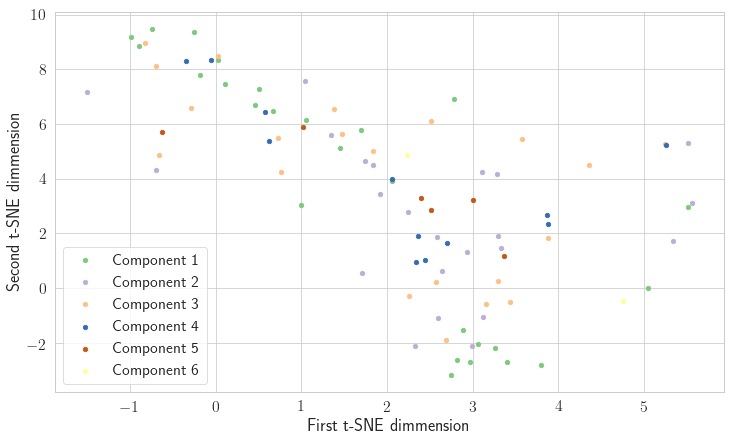

In [82]:
fig, ax = plt.subplots()
for i in pd.unique(clique_index):
    ax.scatter(*data_tsne[clique_index == i].T, s=20, color=colorcycle[i], label=f"Component {i+1}") 
ax.legend(loc='lower left') 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension")
fig.savefig(f"figs/tsne_componnts_perp_30_colored_5_clique_directed.pdf")

In [111]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit_transform(clique_mode) 

Try clustering the points with different algorithms

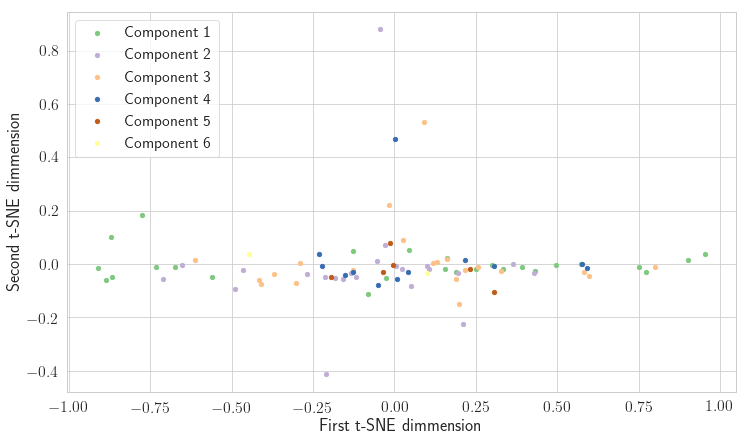

In [113]:
fig, ax = plt.subplots()
for i in pd.unique(clique_index):
    ax.scatter(*data_pca[clique_index == i].T, s=20, color=colorcycle[i], label=f"Component {i+1}") 
ax.legend(loc='upper left') 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension")
fig.savefig(f"figs/pca_componnts_colored_5_clique_directed.pdf")

In [83]:
pd.value_counts(clique_index)

0    26
1    23
2    21
3    12
4     6
5     2
dtype: int64

In [84]:
clstData = misc.standardizeData(clique_mode) 

#### KMeans

In [85]:
kmeans = cluster.KMeans(max_iter=1000, n_jobs=16, n_clusters=6) 
kmeans.fit(clstData)
clst = kmeans.fit_predict(clstData)
np.unique(clst, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([47,  3,  3,  2, 34,  1]))

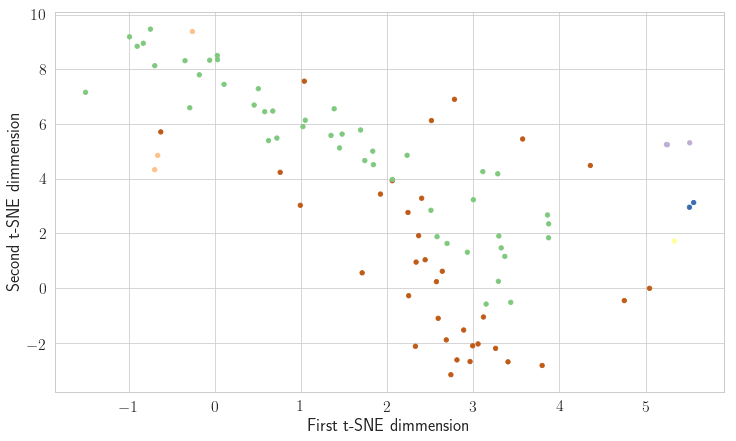

In [86]:
fig, ax = plt.subplots()
ax.scatter(*data_tsne.T, s=20, c=[colorcycle[i] for i in clst], label=f"Component {i+1}") 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension") 
fig.savefig(f"figs/tsne_kmeans_clusters_perp_30_colored_5_clique_directed.pdf") 

#### HDBScan

In [92]:
hdbscan = cluster.DBSCAN(n_jobs=16, min_samples=3)
hdbscan.fit(clstData)
clst = hdbscan.fit_predict(clstData)

pd.value_counts(clst)

-1    75
 1    12
 0     3
dtype: int64

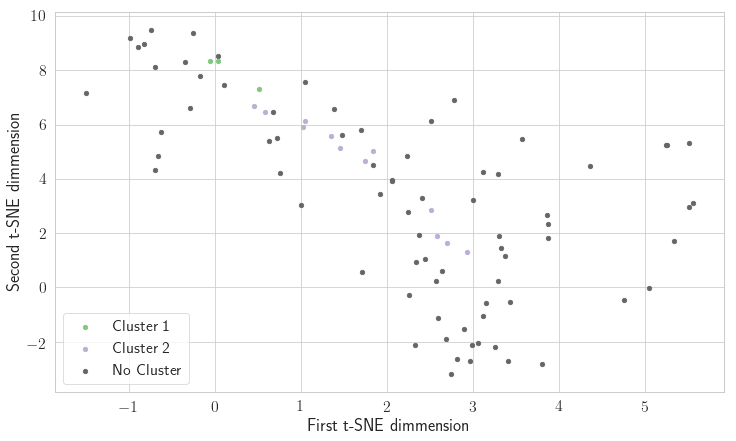

In [93]:
fig, ax = plt.subplots()
for i in [0, 1]:
    ax.scatter(*data_tsne[clst == i].T, s=20, color=colorcycle[i], label=f"Cluster {i+1}") 
ax.scatter(*data_tsne[clst == -1].T, s=20, color=colorcycle[-1], label=f"No Cluster") 
ax.legend(loc='lower left') 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension")
fig.savefig(f"figs/tsne_hdbscan_perp_30_colored_5_clique_directed.pdf")

##### T-SNE with perplexity 5

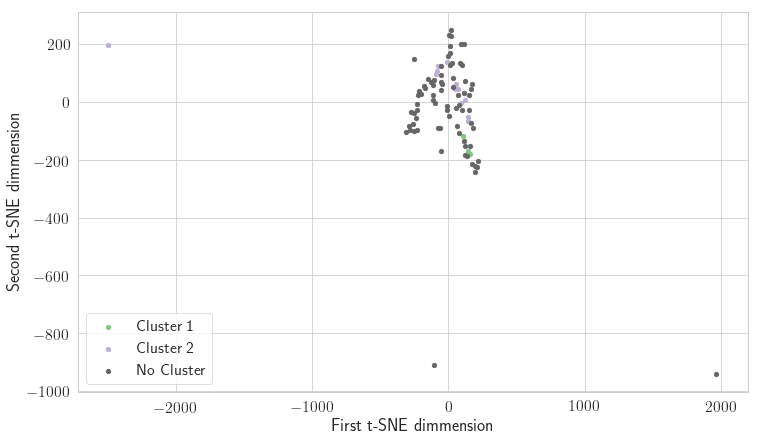

In [95]:
np.random.seed(1234567890) 
tsne = manifold.TSNE(perplexity=5)
data_tsne = tsne.fit_transform(clique_mode)

fig, ax = plt.subplots()
for i in [0, 1]:
    ax.scatter(*data_tsne[clst == i].T, s=20, color=colorcycle[i], label=f"Cluster {i+1}") 
ax.scatter(*data_tsne[clst == -1].T, s=20, color=colorcycle[-1], label=f"No Cluster") 
ax.legend(loc='lower left') 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension") 
fig.savefig(f"figs/tsne_hdbscan_perp_5_seeded_colored_5_clique_directed.pdf")

##### T-SNE with perplexity 30

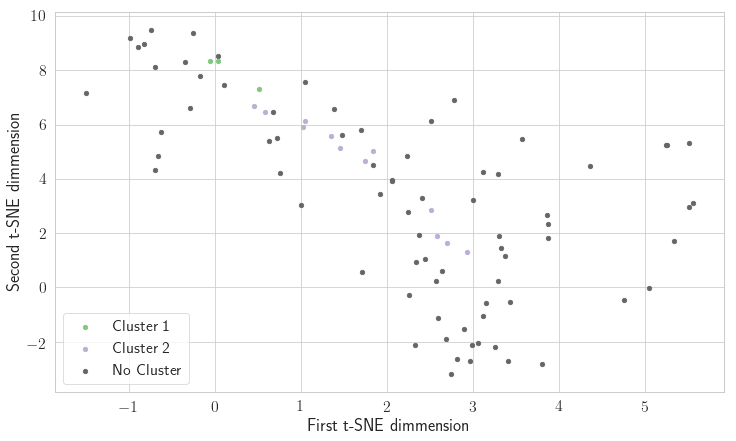

In [97]:
np.random.seed(1234567890)
tsne = manifold.TSNE(perplexity=30)
data_tsne = tsne.fit_transform(clique_mode)

fig, ax = plt.subplots()
for i in [0, 1]:
    ax.scatter(*data_tsne[clst == i].T, s=20, color=colorcycle[i], label=f"Cluster {i+1}") 
ax.scatter(*data_tsne[clst == -1].T, s=20, color=colorcycle[-1], label=f"No Cluster") 
ax.legend(loc='lower left')
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension") 
fig.savefig(f"figs/tsne_hdbscan_perp_30_seeded_colored_5_clique_directed.pdf")

##### T-SNE with perplexity 55

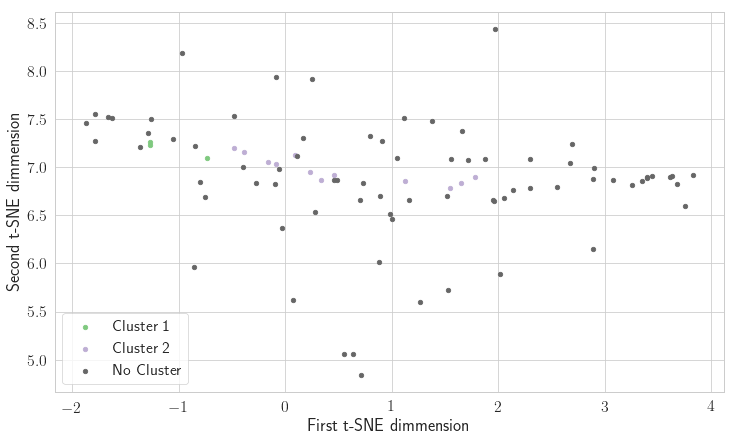

In [99]:
np.random.seed(1234567890)
tsne = manifold.TSNE(perplexity=55)
data_tsne = tsne.fit_transform(clique_mode) 

fig, ax = plt.subplots()
for i in [0, 1]:
    ax.scatter(*data_tsne[clst == i].T, s=20, color=colorcycle[i], label=f"Cluster {i+1}") 
ax.scatter(*data_tsne[clst == -1].T, s=20, color=colorcycle[-1], label=f"No Cluster") 
ax.legend(loc='lower left') 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension") 
fig.savefig(f"figs/tsne_hdbscan_perp_55_seeded_colored_5_clique_directed.pdf")

##### T-SNE with exact calculation instead of the Barnes Hut approximaion, perplexity 30

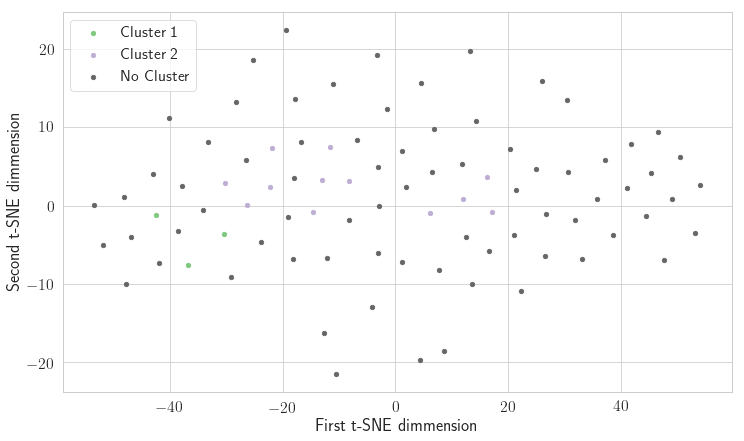

In [100]:
np.random.seed(1234567890)
tsne = manifold.TSNE(perplexity=30, method='exact')
data_tsne = tsne.fit_transform(clique_mode) 

fig, ax = plt.subplots()
for i in [0, 1]:
    ax.scatter(*data_tsne[clst == i].T, s=20, color=colorcycle[i], label=f"Cluster {i+1}") 
ax.scatter(*data_tsne[clst == -1].T, s=20, color=colorcycle[-1], label=f"No Cluster") 
ax.legend(loc='upper left') 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension")
fig.savefig(f"figs/tsne_exact_hdbscan_perp_30_seeded_colored_5_clique_directed.pdf")

#### Spectral clustering

In [101]:
sp_clst = cluster.SpectralClustering(n_jobs=6, n_clusters=6)
clst = sp_clst.fit_predict(clstData)

pd.value_counts(clst)

0    42
4    15
2    11
3    10
5     6
1     6
dtype: int64

In [103]:
np.random.seed(1234567890)
tsne = manifold.TSNE(perplexity=30)
data_tsne = tsne.fit_transform(clique_mode) 

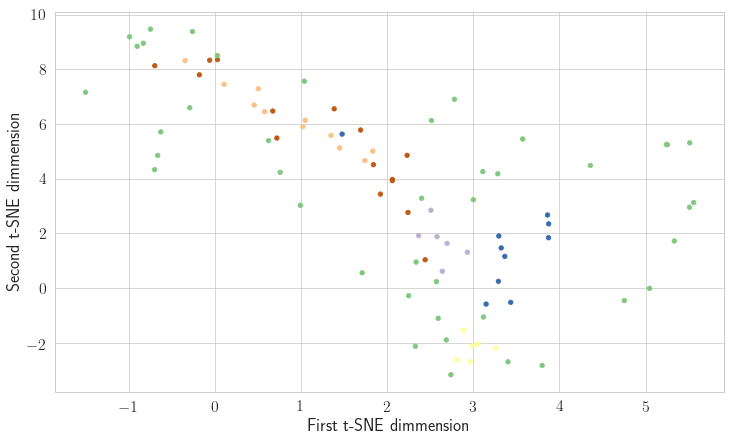

In [104]:
fig, ax = plt.subplots()
ax.scatter(*data_tsne.T, s=20, c=[colorcycle[i] for i in clst], label=f"Component {i+1}")
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension") 
fig.savefig(f"figs/tsne_spectralClustering_perp_30_seeded_colored_5_clique_directed.pdf")

### AgglomerativeClustering

In [105]:
agg_clst = cluster.AgglomerativeClustering(n_clusters=6)
clst = agg_clst.fit_predict(clstData)

pd.value_counts(clst)

2    72
1     6
0     6
4     4
5     1
3     1
dtype: int64

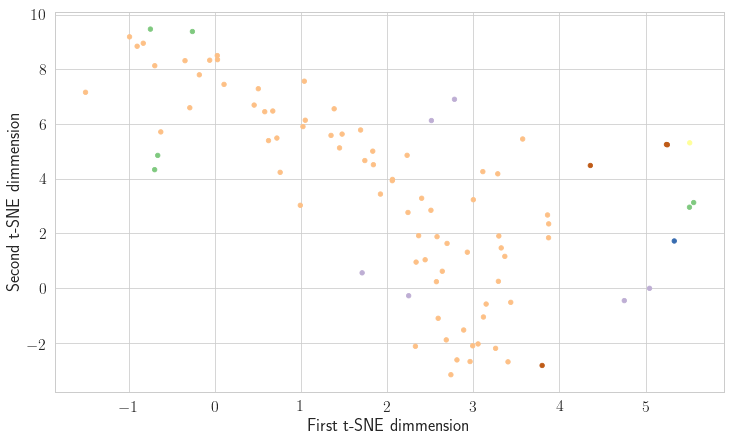

In [107]:
fig, ax = plt.subplots()
ax.scatter(*data_tsne.T, s=20, c=[colorcycle[i] for i in clst], label=f"Component {i+1}") 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension")
fig.savefig(f"figs/tsne_agglomerativeClustering_perp_30_seeded_colored_5_clique_directed.pdf")

### Affinity propagation

In [264]:
aff_clst = cluster.AffinityPropagation()
clst = agg_clst.fit_predict(clstData)

pd.value_counts(clst)

1    67
0    42
2    13
4     5
3     3
5     2
dtype: int64

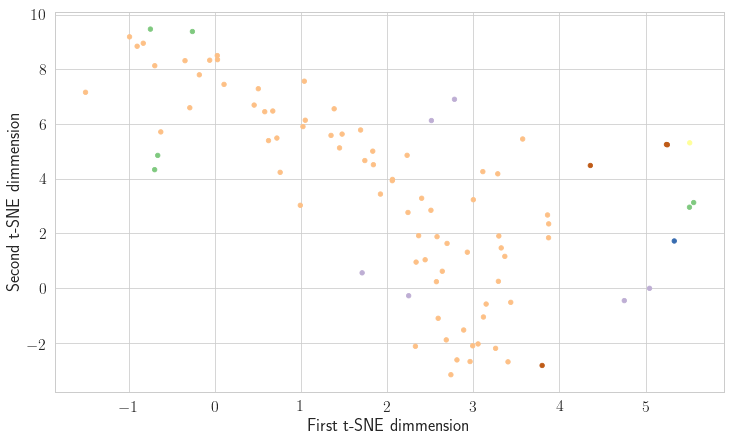

In [108]:
fig, ax = plt.subplots()
ax.scatter(*data_tsne.T, s=20, c=[colorcycle[i] for i in clst], label=f"Component {i+1}") 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension")
fig.savefig(f"figs/tsne_affinityPropagation_perp_30_seeded_colored_5_clique_directed.pdf")